In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# date parser function for the specific date format
date_parser = lambda x: pd.to_datetime(x, format="%d-%m-%y %H:%M")

# Load the datasets
actual_generation = pd.read_excel(
    "Data/Market/actual_generation_hour.xlsx", 
    parse_dates=["Start date"], 
    date_format="%d-%m-%y %H:%M"
    ).set_index("Start date").drop(columns=["End date"])

actual_consumption = pd.read_excel(
    "Data/Market/actual_consumption_hour.xlsx",
    parse_dates=["Start date"], 
    date_format="%d-%m-%y %H:%M"
    ).set_index("Start date").drop(columns=["End date"])

day_ahead_prices = pd.read_excel("Data/Market/day-ahead_prices_hour.xlsx",
    parse_dates=["Start date"],
    date_format="%d-%m-%y %H:%M"
    ).set_index("Start date").drop(columns=["End date"])


In [3]:
# Display the first few rows of each dataframe to verify the changes
actual_generation

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh]
Start date,,,,,,,,,,,,
"Jan 1, 2023 12:00 AM",4365,1275.25,3059.25,28710.50,1.25,129.5,2459.5,3859.25,2067.5,1721.75,42.75,1228.75
"Jan 1, 2023 1:00 AM",4344.75,1226.5,3586.00,29305.00,1.00,129,2458.75,3866.5,2052,1568,126.75,1218.25
"Jan 1, 2023 2:00 AM",4333,1222.5,3842.25,29266.00,1.25,129,2459.75,3860.25,2034.25,1571.5,85.5,1211.5
"Jan 1, 2023 3:00 AM",4338.75,1223.25,3463.25,27008.50,1.00,129,2460.5,3864.75,2037,1564.75,84,1211.75
"Jan 1, 2023 4:00 AM",4353.25,1244,3462.25,26438.75,1.50,128.25,2461,3841,2040.25,1550.5,84,1214.25
...,...,...,...,...,...,...,...,...,...,...,...,...
"Oct 31, 2024 7:00 PM",4610.75,1908.75,3522.25,15330.25,0.00,92,-,10659.75,6776,9085.25,1503.75,982.75
"Oct 31, 2024 8:00 PM",4583.25,1587,3201.75,16392.00,0.00,92,-,9817.75,6050,8621.5,791,967.25
"Oct 31, 2024 9:00 PM",4540,1538.5,3220.00,17175.75,0.00,92,-,9168,5242.25,8070,397.25,961.5


In [4]:
actual_consumption.head()

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh]
Start date,,,
"Jan 1, 2023 12:00 AM",38346.00,6575.00,2023
"Jan 1, 2023 1:00 AM",37777.25,4885.25,1682.5
"Jan 1, 2023 2:00 AM",36939.75,3830.25,3287.5
"Jan 1, 2023 3:00 AM",35932.50,5459.75,4015.75
"Jan 1, 2023 4:00 AM",35486.25,5583.75,4023.5


In [5]:
day_ahead_prices.head()

,Germany/Luxembourg [€/MWh],∅ DE/LU neighbours [€/MWh],Belgium [€/MWh],Denmark 1 [€/MWh],Denmark 2 [€/MWh],France [€/MWh],Netherlands [€/MWh],Norway 2 [€/MWh],Austria [€/MWh],Poland [€/MWh],Sweden 4 [€/MWh],Switzerland [€/MWh],Czech Republic [€/MWh],DE/AT/LU [€/MWh],Northern Italy [€/MWh],Slovenia [€/MWh],Hungary [€/MWh]
Start date,,,,,,,,,,,,,,,,,
"Jan 1, 2023 12:00 AM",-5.17,13.85,-4.39,2.01,2.01,0.00,-3.61,119.32,12.06,18.09,2.01,0.03,4.84,-,195.90,13.31,19.76
"Jan 1, 2023 1:00 AM",-1.07,9.79,-1.75,1.38,1.38,-0.10,-1.46,108.83,-0.10,5.75,1.38,-7.25,-0.35,-,191.09,-0.07,0.19
"Jan 1, 2023 2:00 AM",-1.47,8.91,-1.46,0.09,0.09,-1.33,-1.52,102.39,-0.66,5.27,0.09,-3.99,-0.97,-,187.95,-0.47,0.07
"Jan 1, 2023 3:00 AM",-5.08,6.58,-5.27,0.08,0.08,-4.08,-5.00,92.36,-1.99,5.74,0.08,-7.71,-1.93,-,187.82,-1.56,0.01
"Jan 1, 2023 4:00 AM",-4.49,5.42,-4.41,0.05,0.05,-4.16,-4.60,82.66,-2.42,5.22,0.05,-9.71,-3.07,-,187.74,-1.94,-0.77


In [6]:
actual_generation.columns, actual_consumption.columns, day_ahead_prices.columns

(Index(['Biomass [MWh]', 'Hydropower [MWh]', 'Wind offshore [MWh]',
        'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other renewable [MWh]',
        'Nuclear [MWh]', 'Lignite [MWh]', 'Hard coal [MWh]', 'Fossil gas [MWh]',
        'Hydro pumped storage [MWh]', 'Other conventional [MWh]'],
       dtype='object'),
 Index(['Total (grid load) [MWh]', 'Residual load [MWh]',
        'Hydro pumped storage [MWh]'],
       dtype='object'),
 Index(['Germany/Luxembourg [€/MWh]', '∅ DE/LU neighbours [€/MWh]',
        'Belgium [€/MWh]', 'Denmark 1 [€/MWh]', 'Denmark 2 [€/MWh]',
        'France [€/MWh]', 'Netherlands [€/MWh]', 'Norway 2 [€/MWh]',
        'Austria [€/MWh]', 'Poland [€/MWh]', 'Sweden 4 [€/MWh]',
        'Switzerland [€/MWh]', 'Czech Republic [€/MWh]', 'DE/AT/LU [€/MWh]',
        'Northern Italy [€/MWh]', 'Slovenia [€/MWh]', 'Hungary [€/MWh]'],
       dtype='object'))

In [7]:
# Let's drop unwanted columns
day_ahead_prices.drop(columns=['∅ DE/LU neighbours [€/MWh]',
        'Belgium [€/MWh]', 'Denmark 1 [€/MWh]', 'Denmark 2 [€/MWh]',
        'France [€/MWh]', 'Netherlands [€/MWh]', 'Norway 2 [€/MWh]',
        'Austria [€/MWh]', 'Poland [€/MWh]', 'Sweden 4 [€/MWh]',
        'Switzerland [€/MWh]', 'Czech Republic [€/MWh]', 'DE/AT/LU [€/MWh]',
        'Northern Italy [€/MWh]', 'Slovenia [€/MWh]', 'Hungary [€/MWh]'], inplace=True)

actual_consumption.drop(columns=['Residual load [MWh]', 'Hydro pumped storage [MWh]'], inplace=True)

day_ahead_prices.dtypes, actual_consumption.dtypes

(Germany/Luxembourg [€/MWh]    float64
 dtype: object,
 Total (grid load) [MWh]    float64
 dtype: object)

In [8]:
actual_generation.dtypes

Biomass [MWh]                  object
Hydropower [MWh]               object
Wind offshore [MWh]           float64
Wind onshore [MWh]            float64
Photovoltaics [MWh]           float64
Other renewable [MWh]          object
Nuclear [MWh]                  object
Lignite [MWh]                  object
Hard coal [MWh]                object
Fossil gas [MWh]               object
Hydro pumped storage [MWh]     object
Other conventional [MWh]       object
dtype: object

In [9]:
for col in actual_generation.columns:
    actual_generation[col] = pd.to_numeric(actual_generation[col], errors='coerce')

actual_generation.dtypes

Biomass [MWh]                 float64
Hydropower [MWh]              float64
Wind offshore [MWh]           float64
Wind onshore [MWh]            float64
Photovoltaics [MWh]           float64
Other renewable [MWh]         float64
Nuclear [MWh]                 float64
Lignite [MWh]                 float64
Hard coal [MWh]               float64
Fossil gas [MWh]              float64
Hydro pumped storage [MWh]    float64
Other conventional [MWh]      float64
dtype: object

In [10]:
print(actual_generation.index.duplicated().sum())  # Number of duplicate indices
print(actual_consumption.index.duplicated().sum())
print(day_ahead_prices.index.duplicated().sum())

2
2
2


In [11]:
# Show duplicate rows based on index
print(actual_generation[actual_generation.index.duplicated(keep=False)])
print(actual_consumption[actual_consumption.index.duplicated(keep=False)])
print(day_ahead_prices[day_ahead_prices.index.duplicated(keep=False)])

                      Biomass [MWh]  Hydropower [MWh]  Wind offshore [MWh]  \
Start date                                                                   
Oct 29, 2023 2:00 AM        4103.75           1353.75              6475.75   
Oct 29, 2023 2:00 AM        4088.50           1324.75              6339.00   
Oct 27, 2024 2:00 AM        4121.75           1729.25              2924.25   
Oct 27, 2024 2:00 AM        4133.50           1718.50              2162.00   

                      Wind onshore [MWh]  Photovoltaics [MWh]  \
Start date                                                      
Oct 29, 2023 2:00 AM            22320.25                 1.75   
Oct 29, 2023 2:00 AM            22305.50                 2.25   
Oct 27, 2024 2:00 AM            11943.75                 0.00   
Oct 27, 2024 2:00 AM            11640.00                 0.00   

                      Other renewable [MWh]  Nuclear [MWh]  Lignite [MWh]  \
Start date                                                     

In [12]:
actual_generation = actual_generation.groupby(level=0).mean()
actual_consumption = actual_consumption.groupby(level=0).mean()
day_ahead_prices = day_ahead_prices.groupby(level=0).mean()

In [13]:
print(actual_generation.index.duplicated().sum())
print(actual_consumption.index.duplicated().sum())
print(day_ahead_prices.index.duplicated().sum())

0
0
0


In [14]:
# Let's merge both the dataframes to create a single df

final_df = pd.merge(actual_generation, actual_consumption, left_index=True, right_index=True)

final_df = pd.merge(final_df, day_ahead_prices, left_index=True, right_index=True)

In [15]:
# Our index was improperly sorted, so let's sort it according to date-time

final_df.index = pd.to_datetime(final_df.index)

final_df.sort_index(inplace=True)

final_df

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh],Total (grid load) [MWh],Germany/Luxembourg [€/MWh]
Start date,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,2459.50,3859.25,2067.50,1721.75,42.75,1228.75,38346.00,-5.17
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,2458.75,3866.50,2052.00,1568.00,126.75,1218.25,37777.25,-1.07
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,2459.75,3860.25,2034.25,1571.50,85.50,1211.50,36939.75,-1.47
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,2460.50,3864.75,2037.00,1564.75,84.00,1211.75,35932.50,-5.08
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,2461.00,3841.00,2040.25,1550.50,84.00,1214.25,35486.25,-4.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,4610.75,1908.75,3522.25,15330.25,0.00,92.00,NaN,10659.75,6776.00,9085.25,1503.75,982.75,58955.25,117.84
2024-10-31 20:00:00,4583.25,1587.00,3201.75,16392.00,0.00,92.00,NaN,9817.75,6050.00,8621.50,791.00,967.25,56251.50,105.80
2024-10-31 21:00:00,4540.00,1538.50,3220.00,17175.75,0.00,92.00,NaN,9168.00,5242.25,8070.00,397.25,961.50,53475.50,85.34


In [16]:
final_df.dtypes

Biomass [MWh]                 float64
Hydropower [MWh]              float64
Wind offshore [MWh]           float64
Wind onshore [MWh]            float64
Photovoltaics [MWh]           float64
Other renewable [MWh]         float64
Nuclear [MWh]                 float64
Lignite [MWh]                 float64
Hard coal [MWh]               float64
Fossil gas [MWh]              float64
Hydro pumped storage [MWh]    float64
Other conventional [MWh]      float64
Total (grid load) [MWh]       float64
Germany/Luxembourg [€/MWh]    float64
dtype: object

In [17]:
final_df

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh],Total (grid load) [MWh],Germany/Luxembourg [€/MWh]
Start date,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,2459.50,3859.25,2067.50,1721.75,42.75,1228.75,38346.00,-5.17
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,2458.75,3866.50,2052.00,1568.00,126.75,1218.25,37777.25,-1.07
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,2459.75,3860.25,2034.25,1571.50,85.50,1211.50,36939.75,-1.47
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,2460.50,3864.75,2037.00,1564.75,84.00,1211.75,35932.50,-5.08
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,2461.00,3841.00,2040.25,1550.50,84.00,1214.25,35486.25,-4.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,4610.75,1908.75,3522.25,15330.25,0.00,92.00,NaN,10659.75,6776.00,9085.25,1503.75,982.75,58955.25,117.84
2024-10-31 20:00:00,4583.25,1587.00,3201.75,16392.00,0.00,92.00,NaN,9817.75,6050.00,8621.50,791.00,967.25,56251.50,105.80
2024-10-31 21:00:00,4540.00,1538.50,3220.00,17175.75,0.00,92.00,NaN,9168.00,5242.25,8070.00,397.25,961.50,53475.50,85.34


In [18]:
# Let's rename the last (target) column

final_df.rename(columns={"Germany/Luxembourg [€/MWh]": "Day ahead price"}, inplace=True)

final_df.head()

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh],Total (grid load) [MWh],Day ahead price
Start date,,,,,,,,,,,,,,
2023-01-01 00:00:00,4365.00,1275.25,3059.25,28710.50,1.25,129.50,2459.50,3859.25,2067.50,1721.75,42.75,1228.75,38346.00,-5.17
2023-01-01 01:00:00,4344.75,1226.50,3586.00,29305.00,1.00,129.00,2458.75,3866.50,2052.00,1568.00,126.75,1218.25,37777.25,-1.07
2023-01-01 02:00:00,4333.00,1222.50,3842.25,29266.00,1.25,129.00,2459.75,3860.25,2034.25,1571.50,85.50,1211.50,36939.75,-1.47
2023-01-01 03:00:00,4338.75,1223.25,3463.25,27008.50,1.00,129.00,2460.50,3864.75,2037.00,1564.75,84.00,1211.75,35932.50,-5.08
2023-01-01 04:00:00,4353.25,1244.00,3462.25,26438.75,1.50,128.25,2461.00,3841.00,2040.25,1550.50,84.00,1214.25,35486.25,-4.49


In [19]:
# Checking null values

final_df.isnull().sum()

Biomass [MWh]                   24
Hydropower [MWh]                24
Wind offshore [MWh]              0
Wind onshore [MWh]               0
Photovoltaics [MWh]              0
Other renewable [MWh]           48
Nuclear [MWh]                 6611
Lignite [MWh]                   24
Hard coal [MWh]                 24
Fossil gas [MWh]                24
Hydro pumped storage [MWh]      24
Other conventional [MWh]        24
Total (grid load) [MWh]          0
Day ahead price                  0
dtype: int64

In [20]:
final_df["Biomass [MWh]"] = final_df["Biomass [MWh]"].fillna(0.00)
final_df["Hydropower [MWh]"] = final_df["Hydropower [MWh]"].fillna(0.00)
final_df["Other renewable [MWh]"] = final_df["Other renewable [MWh]"].fillna(0.00)
final_df["Lignite [MWh]"] = final_df["Lignite [MWh]"].fillna(0.00)
final_df["Hard coal [MWh]"] = final_df["Hard coal [MWh]"].fillna(0.00)
final_df["Fossil gas [MWh]"] = final_df["Fossil gas [MWh]"].fillna(0.00)
final_df["Hydro pumped storage [MWh]"] = final_df["Hydro pumped storage [MWh]"].fillna(0.00)
final_df["Other conventional [MWh]"] = final_df["Other conventional [MWh]"].fillna(0.00)

final_df.isnull().sum()

Biomass [MWh]                    0
Hydropower [MWh]                 0
Wind offshore [MWh]              0
Wind onshore [MWh]               0
Photovoltaics [MWh]              0
Other renewable [MWh]            0
Nuclear [MWh]                 6611
Lignite [MWh]                    0
Hard coal [MWh]                  0
Fossil gas [MWh]                 0
Hydro pumped storage [MWh]       0
Other conventional [MWh]         0
Total (grid load) [MWh]          0
Day ahead price                  0
dtype: int64

In [21]:
# Step 1: Basic Summary
final_df.describe()

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh],Total (grid load) [MWh],Day ahead price
count,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,9467.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000
mean,4231.831960,1865.464975,2765.463801,12862.712666,7247.720457,119.065400,712.024849,8352.526861,3741.699372,5588.373927,1233.475767,1296.532537,52290.386390,84.631538
std,356.413514,401.467134,1850.758181,10031.258464,10738.616089,31.555712,1193.916667,3579.532838,2927.897538,2739.577243,1566.977675,166.666907,9100.483345,46.776856
min,0.000000,0.000000,0.000000,145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30909.000000,-500.000000
25%,4021.250000,1604.562500,1105.125000,4895.625000,2.250000,96.000000,0.000000,5203.250000,1724.125000,3378.750000,140.000000,1193.000000,44760.062500,61.620000
50%,4214.250000,1879.750000,2557.875000,10121.000000,372.875000,107.000000,0.000000,8130.500000,2768.625000,5076.250000,481.625000,1322.000000,52219.750000,87.625000
75%,4434.187500,2124.500000,4263.125000,18593.875000,12177.437500,140.750000,2111.625000,10980.437500,4850.812500,7201.750000,1802.062500,1397.937500,59511.562500,110.245000
max,5167.000000,3113.250000,7633.250000,48023.000000,46848.250000,203.750000,3082.250000,17173.250000,15240.500000,16538.500000,8583.750000,2042.500000,75508.250000,656.370000


In [22]:
final_df["Nuclear [MWh]"].describe()

count    9467.000000
mean      712.024849
std      1193.916667
min         0.000000
25%         0.000000
50%         0.000000
75%      2111.625000
max      3082.250000
Name: Nuclear [MWh], dtype: float64

### In order to fix null values for Nuclear [MWh], taking mean as option is not suitable as the description above gives high standard deviation for this feature. So the best option is to fill null values here is the median value, as its less sensitive to outliers.


In [23]:
# let's fix it.

final_df["Nuclear [MWh]"] = final_df["Nuclear [MWh]"].fillna(final_df["Nuclear [MWh]"].median())

final_df.describe()

,Biomass [MWh],Hydropower [MWh],Wind offshore [MWh],Wind onshore [MWh],Photovoltaics [MWh],Other renewable [MWh],Nuclear [MWh],Lignite [MWh],Hard coal [MWh],Fossil gas [MWh],Hydro pumped storage [MWh],Other conventional [MWh],Total (grid load) [MWh],Day ahead price
count,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000,16078.000000
mean,4231.831960,1865.464975,2765.463801,12862.712666,7247.720457,119.065400,419.252348,8352.526861,3741.699372,5588.373927,1233.475767,1296.532537,52290.386390,84.631538
std,356.413514,401.467134,1850.758181,10031.258464,10738.616089,31.555712,980.835513,3579.532838,2927.897538,2739.577243,1566.977675,166.666907,9100.483345,46.776856
min,0.000000,0.000000,0.000000,145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30909.000000,-500.000000
25%,4021.250000,1604.562500,1105.125000,4895.625000,2.250000,96.000000,0.000000,5203.250000,1724.125000,3378.750000,140.000000,1193.000000,44760.062500,61.620000
50%,4214.250000,1879.750000,2557.875000,10121.000000,372.875000,107.000000,0.000000,8130.500000,2768.625000,5076.250000,481.625000,1322.000000,52219.750000,87.625000
75%,4434.187500,2124.500000,4263.125000,18593.875000,12177.437500,140.750000,0.000000,10980.437500,4850.812500,7201.750000,1802.062500,1397.937500,59511.562500,110.245000
max,5167.000000,3113.250000,7633.250000,48023.000000,46848.250000,203.750000,3082.250000,17173.250000,15240.500000,16538.500000,8583.750000,2042.500000,75508.250000,656.370000


In [24]:
# Step 2: Feature selection based on correlation
corr_matrix = final_df.corr()
corr_target = corr_matrix["Day ahead price"].drop("Day ahead price")
selected_features = corr_target[abs(corr_target) > 0.0].index.tolist()

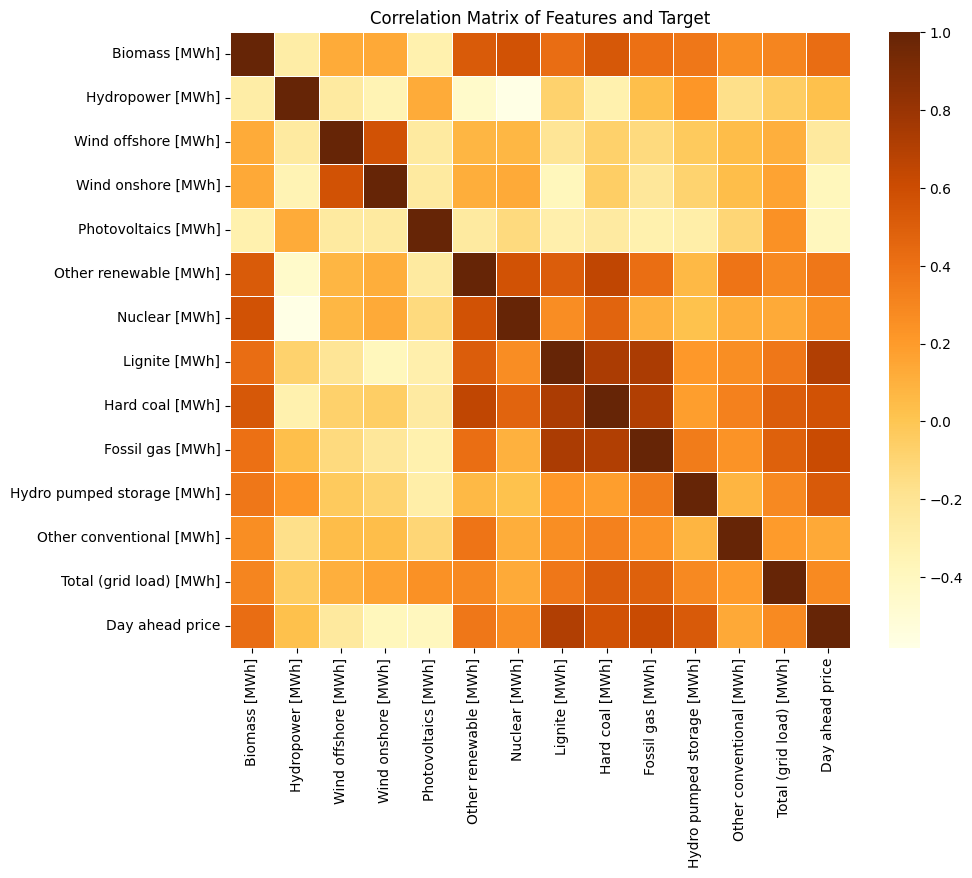

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="YlOrBr", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features and Target")
plt.show()

In [26]:
# Define X (features) and y (target)
X = final_df[selected_features]
y = final_df["Day ahead price"]

In [27]:
# Split into training and test sets
last_day = final_df.index[-1].date()

# Train data: all rows except the last day
X_train = X[final_df.index.date != last_day]
y_train = y[final_df.index.date != last_day]

# Test data: all rows from the last day
X_test = X[final_df.index.date == last_day]
y_test = y[final_df.index.date == last_day]

# Confirm the new splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16054, 13), (24, 13), (16054,), (24,))

In [28]:
# Step 3: Train and evaluate multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Ridge Regression": Ridge(alpha=1.0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf')
}

In [29]:
performance_metrics = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    performance_metrics.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

In [30]:
performance_metrics

[{'Model': 'Linear Regression',
  'MAE': np.float64(4.316908378607119),
  'RMSE': np.float64(5.47262045286662),
  'R2': 0.9025502874280971},
 {'Model': 'Random Forest',
  'MAE': np.float64(6.682645833333333),
  'RMSE': np.float64(8.521006290412537),
  'R2': 0.7637500768451821},
 {'Model': 'Ridge Regression',
  'MAE': np.float64(4.316908254060175),
  'RMSE': np.float64(5.472620239758022),
  'R2': 0.9025502950176499},
 {'Model': 'Gradient Boosting',
  'MAE': np.float64(9.215009556323215),
  'RMSE': np.float64(10.23787579218992),
  'R2': 0.6589566256133701},
 {'Model': 'Support Vector Regressor',
  'MAE': np.float64(7.019583378970914),
  'RMSE': np.float64(8.782643900345969),
  'R2': 0.7490192269505245}]

In [31]:
# Creating a DataFrame to store the results
last_day_results = pd.DataFrame({
    "Date-Time": X_test.index,
    "Actual Price": y_test.values,
    "Predicted Price": y_pred
})

# Resetting the index for better readability
last_day_results.set_index("Date-Time", inplace=True)
last_day_results.index = pd.to_datetime(last_day_results.index)

last_day_results.sort_index()

last_day_results

,Actual Price,Predicted Price
Date-Time,,
2024-10-31 00:00:00,105.16,109.240577
2024-10-31 01:00:00,98.51,104.689768
2024-10-31 02:00:00,96.58,102.041090
2024-10-31 03:00:00,94.81,100.313577
2024-10-31 04:00:00,98.03,101.402864
2024-10-31 05:00:00,102.34,106.676591
2024-10-31 06:00:00,121.15,120.688063
2024-10-31 07:00:00,135.53,132.656148
2024-10-31 08:00:00,133.47,130.473073


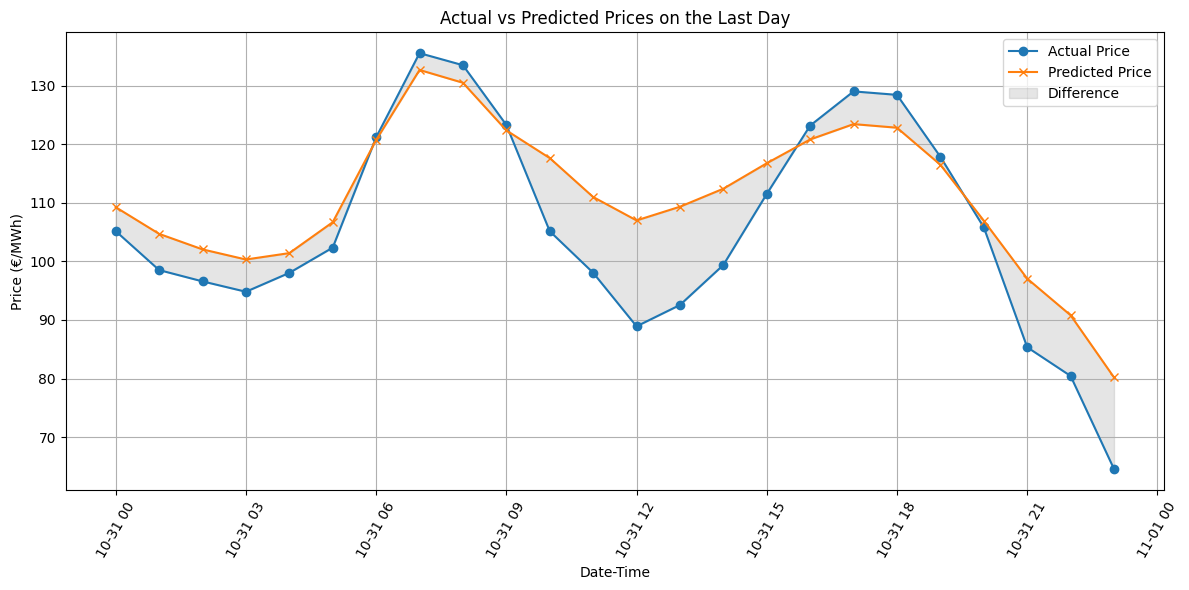

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(last_day_results.index, last_day_results["Actual Price"], label="Actual Price", marker='o')
plt.plot(last_day_results.index, last_day_results["Predicted Price"], label="Predicted Price", marker='x')
plt.fill_between(
    last_day_results.index,
    last_day_results["Actual Price"],
    last_day_results["Predicted Price"],
    color='gray',
    alpha=0.2,
    label="Difference"
)
plt.title("Actual vs Predicted Prices on the Last Day")
plt.xlabel("Date-Time")
plt.ylabel("Price (€/MWh)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()